In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from wordcloud import  WordCloud

In [42]:
perundung_files = glob.glob("./tweets-data/kalimat_bullying_*.csv")
non_perundung_files = glob.glob("./tweets-data/kalimat_bukan_bullying_*.csv")
dfs = []

for file in perundung_files:
    df = pd.read_csv(file)
    dfs.append(df)

for file in non_perundung_files:
    df = pd.read_csv(file)
    dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

print(df_final.shape)
df_final.tail()

(12109, 15)


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
12104,1920156676524773493,Wed May 07 16:40:01 +0000 2025,0,keren banget Tim dari The Rockefeller Foundati...,1920156676524773493,https://pbs.twimg.com/ext_tw_video_thumb/19201...,NaN,in,bali,0,0,0,https://x.com/arthadewils/status/1920156676524...,2539895978,arthadewils
12105,1919884929191534669,Wed May 07 16:34:51 +0000 2025,0,@WarezHimawan @TxtdariHI Jammu dan Kashmir wak...,1920155376898687011,NaN,FelixSihombing5,in,NaN,0,1,0,https://x.com/FelixSihombing5/status/192015537...,883506255074951168,FelixSihombing5
12106,1920079562022535410,Wed May 07 16:33:12 +0000 2025,0,@MintRanchMR Thanks you phi mint sudah menduku...,1920154963264877023,NaN,MintRanchMR,in,BANGTAN BOYS,0,0,0,https://x.com/lilyvk01/status/1920154963264877023,1207466144879108097,lilyvk01
12107,1920154841332265432,Wed May 07 16:32:43 +0000 2025,0,luar biasa! Mendukung penuh pengenalan menu lo...,1920154841332265432,https://pbs.twimg.com/ext_tw_video_thumb/19201...,NaN,in,bandung,0,0,0,https://x.com/candkiranad/status/1920154841332...,2476510207,candkiranad
12108,1920088153035333866,Wed May 07 16:32:24 +0000 2025,0,@YSDreamies App Yt di hp lama udh ga mendukung...,1920154763200770273,https://pbs.twimg.com/media/GqXCk9IbMAMFnfi.jpg,YSDreamies,in,🧚🏻‍♀️🍀,0,0,0,https://x.com/kiyeokiyeo/status/19201547632007...,868075421283172353,kiyeokiyeo


In [43]:
df_perundung=df_final["full_text"]

In [44]:
df_perundung.to_csv("perundung.csv",index=False)

<h1>Preprocessing</h1>

In [ ]:
import re 
import string

In [46]:
df_perundung=pd.read_csv("perundung.csv")

In [47]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text=re.sub(r'\d+','',text)
    text=text.translate(str.maketrans('','',string.punctuation))
    text=text.strip()
    return text
def preprocess_text(df,column):
    df=df.copy()
    df[column]=df[column].apply(clean_text)
    return df

df_perundung=preprocess_text(df_perundung,"full_text")
df_perundung.tail()

,full_text
12104,keren banget tim dari the rockefeller foundati...
12105,jammu dan kashmir waktu itu mayoritas islam na...
12106,thanks you phi mint sudah mendukung nicha
12107,luar biasa mendukung penuh pengenalan menu lok...
12108,app yt di hp lama udh ga mendukung jadi kita l...


In [48]:
df_perundung.dropna(inplace=True)

In [49]:
df_perundung.drop_duplicates(inplace=True)

In [50]:
df_perundung.to_csv("preprocessing_perundung.csv",index=False)

<h1>Labeling Dataset</h1>

In [ ]:
from transformers import  AutoTokenizer, AutoModelForSequenceClassification,TextClassificationPipeline

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_perundung=pd.read_csv("preprocessing_perundung.csv")

In [53]:
df_perundung.tail()

,full_text
11607,keren banget tim dari the rockefeller foundati...
11608,jammu dan kashmir waktu itu mayoritas islam na...
11609,thanks you phi mint sudah mendukung nicha
11610,luar biasa mendukung penuh pengenalan menu lok...
11611,app yt di hp lama udh ga mendukung jadi kita l...


In [9]:
model_labeling="kairaamilanii/IndoBERT-Bullying-Classifier"
tokenizer=AutoTokenizer.from_pretrained(model_labeling)
model=AutoModelForSequenceClassification.from_pretrained(model_labeling)
pipe=TextClassificationPipeline(model=model, tokenizer=tokenizer)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [55]:
predicted_labels=[]
for text in df_perundung["full_text"]:
    result = pipe(text)[0]
    if result["label"] == "LABEL_1":
        predicted_labels.append("Ucapan Perundung")
    else:
        predicted_labels.append("Bukan Ucapan Perundung")

df_perundung["label"]=predicted_labels

In [56]:
df_perundung['label_encoding']= df_perundung['label'].map({'Ucapan Perundung': 1, 'Bukan Ucapan Perundung': 0})
df_perundung.head()

,full_text,label,label_encoding
0,hy org org tolol yg akn mmbela antek antek pki,Ucapan Perundung,1
1,ga bisa manfaatin set piece malah kebobolan da...,Ucapan Perundung,1
2,tolol bgt anjir arsenal kesel gua,Ucapan Perundung,1
3,pelanggaran gajelas si tolol,Ucapan Perundung,1
4,tolol dipelihara anjing mati lu,Ucapan Perundung,1


In [4]:
df_perundung.to_csv("label_hasil_indobert.csv",index=False)

NameError: name 'df_perundung' is not defined

In [4]:
from sklearn.model_selection import  train_test_split
from transformers import  TrainingArguments,Trainer,AutoTokenizer,AutoModelForSequenceClassification,AutoConfig,EarlyStoppingCallback
from sklearn.metrics import  classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils import resample
import torch

In [5]:
df_perundung=pd.read_csv("label_hasil_indobert.csv")

<h1>Visualisasi Dataset</h1>

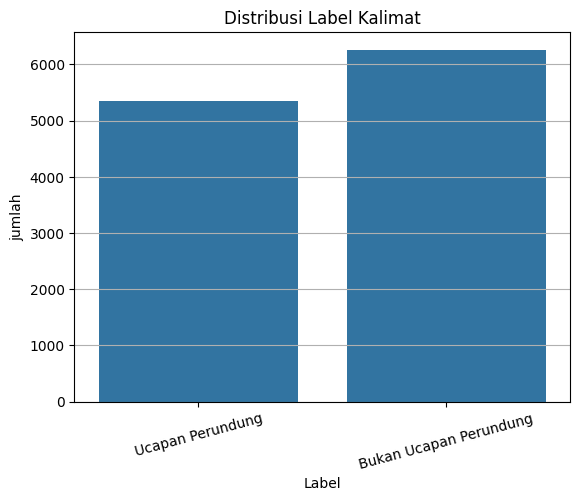

In [13]:
sns.countplot(x='label',data=df_perundung)
plt.title("Distribusi Label Kalimat")
plt.xlabel("Label")
plt.ylabel("jumlah")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

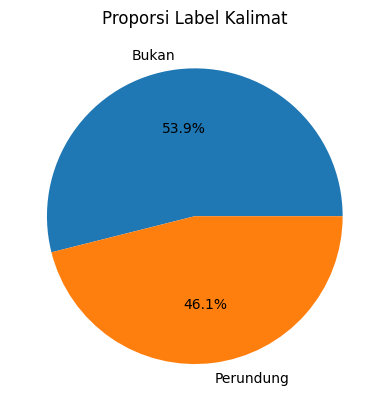

In [14]:
df_perundung['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=["Bukan", "Perundung"])
plt.title("Proporsi Label Kalimat")
plt.ylabel("")
plt.show()


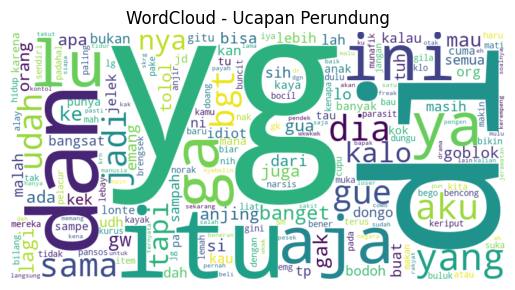

In [15]:
text_perundung = " ".join(df_perundung[df_perundung['label'] == 'Ucapan Perundung']['full_text'])
wordcloud_perundung = WordCloud(width=800, height=400, background_color='white').generate(text_perundung)

plt.imshow(wordcloud_perundung, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Ucapan Perundung")
plt.show()


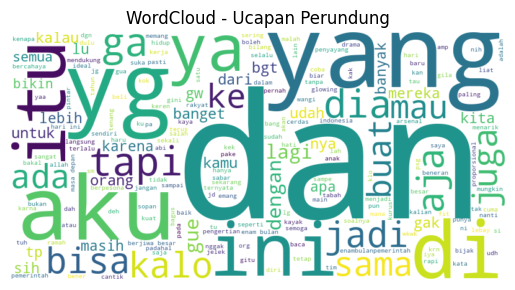

In [16]:
text_bukan_perundung = " ".join(df_perundung[df_perundung['label'] == 'Bukan Ucapan Perundung']['full_text'])
wordcloud_perundung = WordCloud(width=800, height=400, background_color='white').generate(text_bukan_perundung)

plt.imshow(wordcloud_perundung, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Ucapan Perundung")
plt.show()


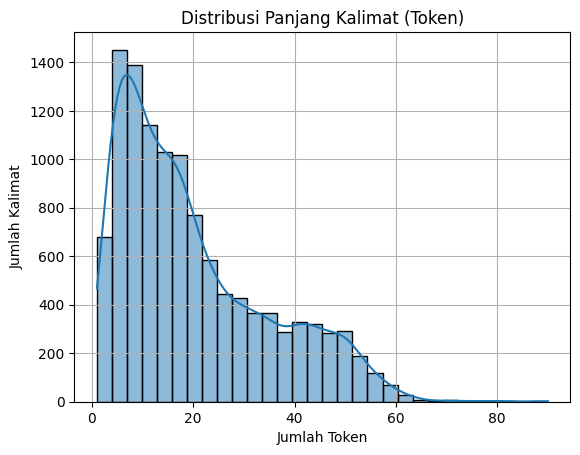

In [17]:
df_perundung['token_count'] = df_perundung['full_text'].apply(lambda x: len(tokenizer.tokenize(x)))
sns.histplot(df_perundung['token_count'], bins=30, kde=True)
plt.title("Distribusi Panjang Kalimat (Token)")
plt.xlabel("Jumlah Token")
plt.ylabel("Jumlah Kalimat")
plt.grid(True)
plt.show()


<h1>Sampling Data</h1>

In [6]:
perundung = df_perundung[df_perundung["label"] == "Ucapan Perundung"]
non_perundung = df_perundung[df_perundung["label"] == "Bukan Ucapan Perundung"]

In [7]:
df_perundung_undersampling = resample(
    non_perundung,
    replace=False,
    n_samples=len(perundung),
    random_state=42
)
df_perundung = pd.concat([perundung, df_perundung_undersampling])
df_perundung = df_perundung.sample(frac=1, random_state=42).reset_index(drop=True)

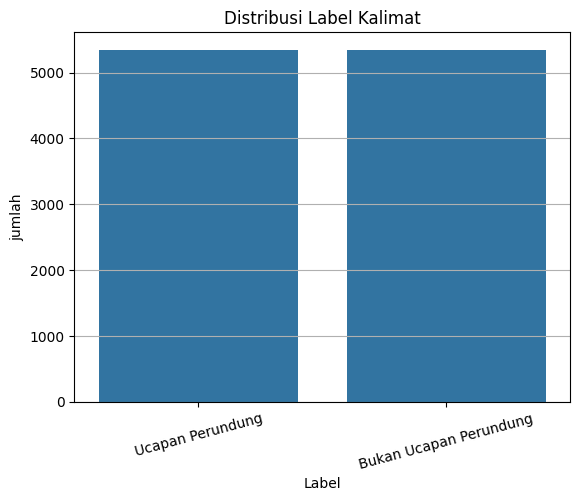

In [20]:
sns.countplot(x='label',data=df_perundung)
plt.title("Distribusi Label Kalimat")
plt.xlabel("Label")
plt.ylabel("jumlah")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()

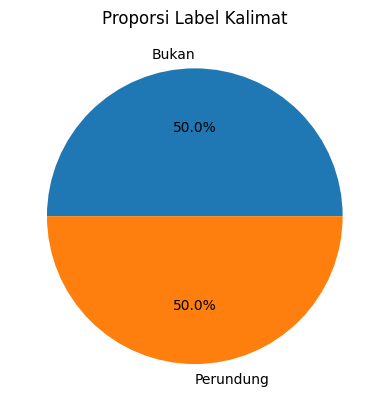

In [21]:
df_perundung['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=["Bukan", "Perundung"])
plt.title("Proporsi Label Kalimat")
plt.ylabel("")
plt.show()


In [8]:
df_perundung.to_csv("dataset_hasil_undersampling.csv",index=False)

In [7]:
df_perundung=pd.read_csv("dataset_hasil_undersampling.csv")

<h1>Split Data</h1>

In [8]:
x=df_perundung["full_text"].tolist()
y=df_perundung["label_encoding"].tolist()

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

<h1>Tokenisasi</h1>

In [6]:
tokenizer=AutoTokenizer.from_pretrained("xlm-roberta-base")
train_tokenizer=tokenizer(x_train,truncation=True,padding=True,max_length=64)
test_tokenizer=tokenizer(x_test,truncation=True,padding=True,max_length=64)

NameError: name 'x_train' is not defined

In [13]:
class PerundungDataset(torch.utils.data.Dataset):
    def __init__(self,encodings,labels):
        self.encodings=encodings
        self.labels=labels
    def __getitem__(self,idx):
        item={k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset=PerundungDataset(train_tokenizer,y_train)
test_dataset=PerundungDataset(test_tokenizer,y_test)

<h1>Modeling</h1>

In [9]:
label2id={"Bukan Ucapan Perundung":0, "Ucapan Perundung":1}
id2label={0:"Bukan Ucapan Perundung", 1:"Ucapan Perundung"}

In [10]:
config=AutoConfig.from_pretrained("xlm-roberta-base",num_labels=2, label2id=label2id, id2label=id2label)
model=AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base",config=config)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you ex

In [27]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     save_total_limit=1,
#     learning_rate=2e-5,
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=32,
#     num_train_epochs=4,
#     weight_decay=0.2,
#     logging_dir="./logs",
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=tokenizer,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
# )

In [16]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=6,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [12]:
initial_eval = trainer.evaluate()
print(f"Eval loss awal (sebelum training): {initial_eval['eval_loss']}")

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 67/67 [01:30<00:00,  1.35s/it]

Eval loss awal (sebelum training): 0.7013362646102905


In [13]:
trainer.train()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 10/1608 [01:08<3:00:29,  6.78s/it]

{'loss': 0.6884, 'learning_rate': 1.9875621890547267e-05, 'epoch': 0.04}


  1%|          | 20/1608 [02:15<2:58:25,  6.74s/it]

{'loss': 0.6912, 'learning_rate': 1.9751243781094528e-05, 'epoch': 0.07}


  2%|▏         | 30/1608 [03:23<3:01:20,  6.90s/it]

{'loss': 0.7025, 'learning_rate': 1.9626865671641793e-05, 'epoch': 0.11}


  2%|▏         | 40/1608 [04:31<2:56:24,  6.75s/it]

{'loss': 0.6721, 'learning_rate': 1.9502487562189055e-05, 'epoch': 0.15}


  3%|▎         | 50/1608 [05:39<2:55:11,  6.75s/it]

{'loss': 0.5924, 'learning_rate': 1.937810945273632e-05, 'epoch': 0.19}


  4%|▎         | 60/1608 [06:47<2:54:43,  6.77s/it]

{'loss': 0.5564, 'learning_rate': 1.9253731343283585e-05, 'epoch': 0.22}


  4%|▍         | 70/1608 [07:54<2:53:27,  6.77s/it]

{'loss': 0.5865, 'learning_rate': 1.9129353233830846e-05, 'epoch': 0.26}


  5%|▍         | 80/1608 [09:02<2:51:24,  6.73s/it]

{'loss': 0.5195, 'learning_rate': 1.900497512437811e-05, 'epoch': 0.3}


  6%|▌         | 90/1608 [10:09<2:50:45,  6.75s/it]

{'loss': 0.4853, 'learning_rate': 1.8880597014925376e-05, 'epoch': 0.34}


  6%|▌         | 100/1608 [11:17<2:49:38,  6.75s/it]

{'loss': 0.5817, 'learning_rate': 1.8756218905472638e-05, 'epoch': 0.37}


  7%|▋         | 110/1608 [12:25<2:48:20,  6.74s/it]

{'loss': 0.4798, 'learning_rate': 1.8631840796019903e-05, 'epoch': 0.41}


  7%|▋         | 120/1608 [13:32<2:47:06,  6.74s/it]

{'loss': 0.5434, 'learning_rate': 1.8507462686567165e-05, 'epoch': 0.45}


  8%|▊         | 130/1608 [14:40<2:46:59,  6.78s/it]

{'loss': 0.5137, 'learning_rate': 1.838308457711443e-05, 'epoch': 0.49}


  9%|▊         | 140/1608 [15:47<2:45:29,  6.76s/it]

{'loss': 0.5338, 'learning_rate': 1.8258706467661695e-05, 'epoch': 0.52}


  9%|▉         | 150/1608 [16:55<2:44:24,  6.77s/it]

{'loss': 0.4578, 'learning_rate': 1.8134328358208956e-05, 'epoch': 0.56}


 10%|▉         | 160/1608 [18:03<2:43:09,  6.76s/it]

{'loss': 0.471, 'learning_rate': 1.800995024875622e-05, 'epoch': 0.6}


 11%|█         | 170/1608 [19:12<2:42:50,  6.79s/it]

{'loss': 0.4646, 'learning_rate': 1.7885572139303483e-05, 'epoch': 0.63}


 11%|█         | 180/1608 [20:19<2:40:34,  6.75s/it]

{'loss': 0.4109, 'learning_rate': 1.7761194029850748e-05, 'epoch': 0.67}


 12%|█▏        | 190/1608 [21:27<2:39:21,  6.74s/it]

{'loss': 0.5109, 'learning_rate': 1.7636815920398013e-05, 'epoch': 0.71}


 12%|█▏        | 200/1608 [22:34<2:38:38,  6.76s/it]

{'loss': 0.4626, 'learning_rate': 1.7512437810945274e-05, 'epoch': 0.75}


 13%|█▎        | 210/1608 [23:42<2:37:06,  6.74s/it]

{'loss': 0.3721, 'learning_rate': 1.738805970149254e-05, 'epoch': 0.78}


 14%|█▎        | 220/1608 [24:49<2:36:05,  6.75s/it]

{'loss': 0.431, 'learning_rate': 1.7263681592039804e-05, 'epoch': 0.82}


 14%|█▍        | 230/1608 [25:57<2:35:03,  6.75s/it]

{'loss': 0.3765, 'learning_rate': 1.7139303482587066e-05, 'epoch': 0.86}


 15%|█▍        | 240/1608 [27:05<2:33:46,  6.74s/it]

{'loss': 0.3612, 'learning_rate': 1.701492537313433e-05, 'epoch': 0.9}


 16%|█▌        | 250/1608 [28:13<2:33:46,  6.79s/it]

{'loss': 0.4152, 'learning_rate': 1.6890547263681593e-05, 'epoch': 0.93}


 16%|█▌        | 260/1608 [29:20<2:31:26,  6.74s/it]

{'loss': 0.3598, 'learning_rate': 1.6766169154228858e-05, 'epoch': 0.97}


                                                    
 17%|█▋        | 268/1608 [31:47<2:14:47,  6.04s/it]

{'eval_loss': 0.3822854161262512, 'eval_runtime': 95.1656, 'eval_samples_per_second': 22.487, 'eval_steps_per_second': 0.704, 'epoch': 1.0}


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 17%|█▋        | 270/1608 [32:23<11:32:22, 31.05s/it]

{'loss': 0.3795, 'learning_rate': 1.6641791044776122e-05, 'epoch': 1.01}


 17%|█▋        | 280/1608 [33:30<2:45:05,  7.46s/it] 

{'loss': 0.3361, 'learning_rate': 1.6517412935323384e-05, 'epoch': 1.04}


 18%|█▊        | 290/1608 [34:38<2:28:51,  6.78s/it]

{'loss': 0.3352, 'learning_rate': 1.639303482587065e-05, 'epoch': 1.08}


 19%|█▊        | 300/1608 [35:46<2:27:28,  6.77s/it]

{'loss': 0.3443, 'learning_rate': 1.626865671641791e-05, 'epoch': 1.12}


 19%|█▉        | 310/1608 [36:54<2:26:47,  6.79s/it]

{'loss': 0.3516, 'learning_rate': 1.6144278606965176e-05, 'epoch': 1.16}


 20%|█▉        | 320/1608 [38:01<2:24:35,  6.74s/it]

{'loss': 0.3426, 'learning_rate': 1.601990049751244e-05, 'epoch': 1.19}


 21%|██        | 330/1608 [39:09<2:23:08,  6.72s/it]

{'loss': 0.3333, 'learning_rate': 1.5895522388059702e-05, 'epoch': 1.23}


 21%|██        | 340/1608 [40:16<2:22:51,  6.76s/it]

{'loss': 0.3268, 'learning_rate': 1.5771144278606967e-05, 'epoch': 1.27}


 22%|██▏       | 350/1608 [41:25<2:24:28,  6.89s/it]

{'loss': 0.3878, 'learning_rate': 1.564676616915423e-05, 'epoch': 1.31}


 22%|██▏       | 360/1608 [42:33<2:21:09,  6.79s/it]

{'loss': 0.3959, 'learning_rate': 1.5522388059701494e-05, 'epoch': 1.34}


 23%|██▎       | 370/1608 [43:40<2:19:11,  6.75s/it]

{'loss': 0.3303, 'learning_rate': 1.539800995024876e-05, 'epoch': 1.38}


 24%|██▎       | 380/1608 [44:48<2:17:56,  6.74s/it]

{'loss': 0.381, 'learning_rate': 1.527363184079602e-05, 'epoch': 1.42}


 24%|██▍       | 390/1608 [45:56<2:17:28,  6.77s/it]

{'loss': 0.3706, 'learning_rate': 1.5149253731343285e-05, 'epoch': 1.46}


 25%|██▍       | 400/1608 [47:03<2:15:16,  6.72s/it]

{'loss': 0.3133, 'learning_rate': 1.5024875621890549e-05, 'epoch': 1.49}


 25%|██▌       | 410/1608 [48:10<2:14:28,  6.74s/it]

{'loss': 0.3138, 'learning_rate': 1.4900497512437812e-05, 'epoch': 1.53}


 26%|██▌       | 420/1608 [49:18<2:13:32,  6.74s/it]

{'loss': 0.3026, 'learning_rate': 1.4776119402985077e-05, 'epoch': 1.57}


 27%|██▋       | 430/1608 [50:26<2:12:38,  6.76s/it]

{'loss': 0.3851, 'learning_rate': 1.465174129353234e-05, 'epoch': 1.6}


 27%|██▋       | 440/1608 [51:33<2:11:01,  6.73s/it]

{'loss': 0.314, 'learning_rate': 1.4527363184079604e-05, 'epoch': 1.64}


 28%|██▊       | 450/1608 [52:41<2:10:47,  6.78s/it]

{'loss': 0.2702, 'learning_rate': 1.4402985074626867e-05, 'epoch': 1.68}


 29%|██▊       | 460/1608 [53:48<2:09:19,  6.76s/it]

{'loss': 0.3947, 'learning_rate': 1.427860696517413e-05, 'epoch': 1.72}


 29%|██▉       | 470/1608 [54:56<2:07:47,  6.74s/it]

{'loss': 0.2883, 'learning_rate': 1.4154228855721395e-05, 'epoch': 1.75}


 30%|██▉       | 480/1608 [56:03<2:06:54,  6.75s/it]

{'loss': 0.2987, 'learning_rate': 1.4029850746268658e-05, 'epoch': 1.79}


 30%|███       | 490/1608 [57:11<2:05:13,  6.72s/it]

{'loss': 0.3218, 'learning_rate': 1.3905472636815922e-05, 'epoch': 1.83}


 31%|███       | 500/1608 [58:18<2:04:31,  6.74s/it]

{'loss': 0.3336, 'learning_rate': 1.3781094527363185e-05, 'epoch': 1.87}


 32%|███▏      | 510/1608 [59:26<2:03:35,  6.75s/it]

{'loss': 0.2853, 'learning_rate': 1.365671641791045e-05, 'epoch': 1.9}


 32%|███▏      | 520/1608 [1:00:33<2:02:03,  6.73s/it]

{'loss': 0.2979, 'learning_rate': 1.3532338308457713e-05, 'epoch': 1.94}


 33%|███▎      | 530/1608 [1:01:41<2:01:07,  6.74s/it]

{'loss': 0.3322, 'learning_rate': 1.3407960199004977e-05, 'epoch': 1.98}


                                                      
 33%|███▎      | 536/1608 [1:03:54<1:47:41,  6.03s/it]

{'eval_loss': 0.3837781250476837, 'eval_runtime': 95.4342, 'eval_samples_per_second': 22.424, 'eval_steps_per_second': 0.702, 'epoch': 2.0}


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 34%|███▎      | 540/1608 [1:04:35<5:15:46, 17.74s/it] 

{'loss': 0.3199, 'learning_rate': 1.328358208955224e-05, 'epoch': 2.01}


 34%|███▍      | 550/1608 [1:05:41<2:02:42,  6.96s/it]

{'loss': 0.2273, 'learning_rate': 1.3159203980099505e-05, 'epoch': 2.05}


 35%|███▍      | 560/1608 [1:06:48<1:56:16,  6.66s/it]

{'loss': 0.2417, 'learning_rate': 1.3034825870646768e-05, 'epoch': 2.09}


 35%|███▌      | 570/1608 [1:07:55<1:54:50,  6.64s/it]

{'loss': 0.2756, 'learning_rate': 1.2910447761194032e-05, 'epoch': 2.13}


 36%|███▌      | 580/1608 [1:09:01<1:53:27,  6.62s/it]

{'loss': 0.2582, 'learning_rate': 1.2786069651741295e-05, 'epoch': 2.16}


 37%|███▋      | 590/1608 [1:10:07<1:52:38,  6.64s/it]

{'loss': 0.2994, 'learning_rate': 1.2661691542288558e-05, 'epoch': 2.2}


 37%|███▋      | 600/1608 [1:11:14<1:51:33,  6.64s/it]

{'loss': 0.2117, 'learning_rate': 1.2537313432835823e-05, 'epoch': 2.24}


 38%|███▊      | 610/1608 [1:12:20<1:50:11,  6.62s/it]

{'loss': 0.2177, 'learning_rate': 1.2412935323383086e-05, 'epoch': 2.28}


 39%|███▊      | 620/1608 [1:13:27<1:49:23,  6.64s/it]

{'loss': 0.2702, 'learning_rate': 1.228855721393035e-05, 'epoch': 2.31}


 39%|███▉      | 630/1608 [1:14:33<1:48:20,  6.65s/it]

{'loss': 0.208, 'learning_rate': 1.2164179104477613e-05, 'epoch': 2.35}


 40%|███▉      | 640/1608 [1:15:40<1:47:16,  6.65s/it]

{'loss': 0.2557, 'learning_rate': 1.2039800995024878e-05, 'epoch': 2.39}


 40%|████      | 650/1608 [1:16:46<1:46:03,  6.64s/it]

{'loss': 0.2905, 'learning_rate': 1.1915422885572141e-05, 'epoch': 2.43}


 41%|████      | 660/1608 [1:17:52<1:44:47,  6.63s/it]

{'loss': 0.2491, 'learning_rate': 1.1791044776119405e-05, 'epoch': 2.46}


 42%|████▏     | 670/1608 [1:19:00<1:46:09,  6.79s/it]

{'loss': 0.1967, 'learning_rate': 1.1666666666666668e-05, 'epoch': 2.5}


 42%|████▏     | 680/1608 [1:20:06<1:42:37,  6.63s/it]

{'loss': 0.2289, 'learning_rate': 1.1542288557213931e-05, 'epoch': 2.54}


 43%|████▎     | 690/1608 [1:21:12<1:41:19,  6.62s/it]

{'loss': 0.2307, 'learning_rate': 1.1417910447761196e-05, 'epoch': 2.57}


 44%|████▎     | 700/1608 [1:22:19<1:40:34,  6.65s/it]

{'loss': 0.2654, 'learning_rate': 1.129353233830846e-05, 'epoch': 2.61}


 44%|████▍     | 710/1608 [1:23:26<1:39:52,  6.67s/it]

{'loss': 0.2674, 'learning_rate': 1.1169154228855723e-05, 'epoch': 2.65}


 45%|████▍     | 720/1608 [1:24:32<1:38:09,  6.63s/it]

{'loss': 0.2527, 'learning_rate': 1.1044776119402986e-05, 'epoch': 2.69}


 45%|████▌     | 730/1608 [1:25:39<1:37:06,  6.64s/it]

{'loss': 0.2771, 'learning_rate': 1.0920398009950251e-05, 'epoch': 2.72}


 46%|████▌     | 740/1608 [1:26:45<1:35:39,  6.61s/it]

{'loss': 0.2027, 'learning_rate': 1.0796019900497514e-05, 'epoch': 2.76}


 47%|████▋     | 750/1608 [1:27:51<1:34:35,  6.61s/it]

{'loss': 0.2642, 'learning_rate': 1.0671641791044778e-05, 'epoch': 2.8}


 47%|████▋     | 760/1608 [1:28:58<1:33:47,  6.64s/it]

{'loss': 0.3402, 'learning_rate': 1.0547263681592041e-05, 'epoch': 2.84}


 48%|████▊     | 770/1608 [1:30:04<1:32:27,  6.62s/it]

{'loss': 0.1853, 'learning_rate': 1.0422885572139306e-05, 'epoch': 2.87}


 49%|████▊     | 780/1608 [1:31:11<1:31:04,  6.60s/it]

{'loss': 0.2565, 'learning_rate': 1.029850746268657e-05, 'epoch': 2.91}


 49%|████▉     | 790/1608 [1:32:17<1:30:14,  6.62s/it]

{'loss': 0.2417, 'learning_rate': 1.0174129353233833e-05, 'epoch': 2.95}


 50%|████▉     | 800/1608 [1:33:23<1:28:57,  6.61s/it]

{'loss': 0.2149, 'learning_rate': 1.0049751243781096e-05, 'epoch': 2.99}


                                                      
 50%|█████     | 804/1608 [1:35:21<1:19:33,  5.94s/it]

{'eval_loss': 0.3442247807979584, 'eval_runtime': 93.1422, 'eval_samples_per_second': 22.976, 'eval_steps_per_second': 0.719, 'epoch': 3.0}


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 50%|█████     | 810/1608 [1:36:15<2:40:08, 12.04s/it]

{'loss': 0.234, 'learning_rate': 9.925373134328359e-06, 'epoch': 3.02}


 51%|█████     | 820/1608 [1:37:23<1:30:26,  6.89s/it]

{'loss': 0.1356, 'learning_rate': 9.800995024875622e-06, 'epoch': 3.06}


 52%|█████▏    | 830/1608 [1:38:30<1:27:34,  6.75s/it]

{'loss': 0.2, 'learning_rate': 9.676616915422886e-06, 'epoch': 3.1}


 52%|█████▏    | 840/1608 [1:39:38<1:26:04,  6.72s/it]

{'loss': 0.2391, 'learning_rate': 9.552238805970149e-06, 'epoch': 3.13}


 53%|█████▎    | 850/1608 [1:40:45<1:25:29,  6.77s/it]

{'loss': 0.1578, 'learning_rate': 9.427860696517414e-06, 'epoch': 3.17}


 53%|█████▎    | 860/1608 [1:41:53<1:24:24,  6.77s/it]

{'loss': 0.1826, 'learning_rate': 9.303482587064677e-06, 'epoch': 3.21}


 54%|█████▍    | 870/1608 [1:43:01<1:22:44,  6.73s/it]

{'loss': 0.1868, 'learning_rate': 9.17910447761194e-06, 'epoch': 3.25}


 55%|█████▍    | 880/1608 [1:44:08<1:22:08,  6.77s/it]

{'loss': 0.2018, 'learning_rate': 9.054726368159204e-06, 'epoch': 3.28}


 55%|█████▌    | 890/1608 [1:45:16<1:20:21,  6.72s/it]

{'loss': 0.1879, 'learning_rate': 8.930348258706469e-06, 'epoch': 3.32}


 56%|█████▌    | 900/1608 [1:46:23<1:19:37,  6.75s/it]

{'loss': 0.176, 'learning_rate': 8.805970149253732e-06, 'epoch': 3.36}


 57%|█████▋    | 910/1608 [1:47:31<1:18:25,  6.74s/it]

{'loss': 0.1957, 'learning_rate': 8.681592039800995e-06, 'epoch': 3.4}


 57%|█████▋    | 920/1608 [1:48:38<1:17:28,  6.76s/it]

{'loss': 0.2701, 'learning_rate': 8.557213930348259e-06, 'epoch': 3.43}


 58%|█████▊    | 930/1608 [1:49:47<1:16:35,  6.78s/it]

{'loss': 0.1955, 'learning_rate': 8.432835820895524e-06, 'epoch': 3.47}


 58%|█████▊    | 940/1608 [1:50:55<1:15:39,  6.80s/it]

{'loss': 0.1913, 'learning_rate': 8.308457711442787e-06, 'epoch': 3.51}


 59%|█████▉    | 950/1608 [1:52:02<1:14:14,  6.77s/it]

{'loss': 0.2124, 'learning_rate': 8.18407960199005e-06, 'epoch': 3.54}


 60%|█████▉    | 960/1608 [1:53:10<1:12:55,  6.75s/it]

{'loss': 0.1395, 'learning_rate': 8.059701492537314e-06, 'epoch': 3.58}


 60%|██████    | 970/1608 [1:54:17<1:11:15,  6.70s/it]

{'loss': 0.1986, 'learning_rate': 7.935323383084577e-06, 'epoch': 3.62}


 61%|██████    | 980/1608 [1:55:25<1:10:31,  6.74s/it]

{'loss': 0.2213, 'learning_rate': 7.810945273631842e-06, 'epoch': 3.66}


 62%|██████▏   | 990/1608 [1:56:32<1:09:16,  6.73s/it]

{'loss': 0.2514, 'learning_rate': 7.686567164179105e-06, 'epoch': 3.69}


 62%|██████▏   | 1000/1608 [1:57:39<1:08:05,  6.72s/it]

{'loss': 0.2033, 'learning_rate': 7.5621890547263685e-06, 'epoch': 3.73}


 63%|██████▎   | 1010/1608 [1:58:47<1:07:30,  6.77s/it]

{'loss': 0.1755, 'learning_rate': 7.437810945273633e-06, 'epoch': 3.77}


 63%|██████▎   | 1020/1608 [1:59:55<1:06:03,  6.74s/it]

{'loss': 0.1592, 'learning_rate': 7.313432835820896e-06, 'epoch': 3.81}


 64%|██████▍   | 1030/1608 [2:01:03<1:05:01,  6.75s/it]

{'loss': 0.1771, 'learning_rate': 7.18905472636816e-06, 'epoch': 3.84}


 65%|██████▍   | 1040/1608 [2:02:10<1:04:03,  6.77s/it]

{'loss': 0.1892, 'learning_rate': 7.064676616915423e-06, 'epoch': 3.88}


 65%|██████▌   | 1050/1608 [2:03:18<1:02:38,  6.74s/it]

{'loss': 0.199, 'learning_rate': 6.9402985074626876e-06, 'epoch': 3.92}


 66%|██████▌   | 1060/1608 [2:04:26<1:02:28,  6.84s/it]

{'loss': 0.2397, 'learning_rate': 6.815920398009951e-06, 'epoch': 3.96}


 67%|██████▋   | 1070/1608 [2:05:33<1:00:38,  6.76s/it]

{'loss': 0.1424, 'learning_rate': 6.691542288557214e-06, 'epoch': 3.99}


                                                       
 67%|██████▋   | 1072/1608 [2:07:20<53:57,  6.04s/it]

{'eval_loss': 0.38338324427604675, 'eval_runtime': 95.4479, 'eval_samples_per_second': 22.421, 'eval_steps_per_second': 0.702, 'epoch': 4.0}


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 67%|██████▋   | 1080/1608 [2:08:27<1:22:21,  9.36s/it]

{'loss': 0.112, 'learning_rate': 6.567164179104478e-06, 'epoch': 4.03}


 68%|██████▊   | 1090/1608 [2:09:35<58:50,  6.82s/it]  

{'loss': 0.1571, 'learning_rate': 6.442786069651742e-06, 'epoch': 4.07}


 68%|██████▊   | 1100/1608 [2:10:43<57:16,  6.76s/it]

{'loss': 0.2154, 'learning_rate': 6.318407960199006e-06, 'epoch': 4.1}


 69%|██████▉   | 1110/1608 [2:11:50<55:59,  6.75s/it]

{'loss': 0.1576, 'learning_rate': 6.194029850746269e-06, 'epoch': 4.14}


 70%|██████▉   | 1120/1608 [2:12:58<54:53,  6.75s/it]

{'loss': 0.1587, 'learning_rate': 6.069651741293533e-06, 'epoch': 4.18}


 70%|███████   | 1130/1608 [2:14:06<53:50,  6.76s/it]

{'loss': 0.1506, 'learning_rate': 5.9452736318407965e-06, 'epoch': 4.22}


 71%|███████   | 1140/1608 [2:15:13<52:34,  6.74s/it]

{'loss': 0.1289, 'learning_rate': 5.820895522388061e-06, 'epoch': 4.25}


 72%|███████▏  | 1150/1608 [2:16:21<51:29,  6.75s/it]

{'loss': 0.1575, 'learning_rate': 5.696517412935324e-06, 'epoch': 4.29}


 72%|███████▏  | 1160/1608 [2:17:29<50:28,  6.76s/it]

{'loss': 0.101, 'learning_rate': 5.572139303482588e-06, 'epoch': 4.33}


 73%|███████▎  | 1170/1608 [2:18:36<49:12,  6.74s/it]

{'loss': 0.1435, 'learning_rate': 5.447761194029851e-06, 'epoch': 4.37}


 73%|███████▎  | 1180/1608 [2:19:44<48:39,  6.82s/it]

{'loss': 0.117, 'learning_rate': 5.323383084577115e-06, 'epoch': 4.4}


 74%|███████▍  | 1190/1608 [2:20:52<46:59,  6.75s/it]

{'loss': 0.1564, 'learning_rate': 5.199004975124379e-06, 'epoch': 4.44}


 75%|███████▍  | 1200/1608 [2:21:59<45:49,  6.74s/it]

{'loss': 0.1534, 'learning_rate': 5.074626865671642e-06, 'epoch': 4.48}


 75%|███████▌  | 1210/1608 [2:23:07<44:45,  6.75s/it]

{'loss': 0.1094, 'learning_rate': 4.950248756218906e-06, 'epoch': 4.51}


 76%|███████▌  | 1220/1608 [2:24:14<43:30,  6.73s/it]

{'loss': 0.1491, 'learning_rate': 4.8258706467661695e-06, 'epoch': 4.55}


 76%|███████▋  | 1230/1608 [2:25:22<42:28,  6.74s/it]

{'loss': 0.1528, 'learning_rate': 4.701492537313434e-06, 'epoch': 4.59}


 77%|███████▋  | 1240/1608 [2:26:30<41:27,  6.76s/it]

{'loss': 0.1108, 'learning_rate': 4.577114427860697e-06, 'epoch': 4.63}


 78%|███████▊  | 1250/1608 [2:27:37<40:14,  6.74s/it]

{'loss': 0.116, 'learning_rate': 4.452736318407961e-06, 'epoch': 4.66}


 78%|███████▊  | 1260/1608 [2:28:45<39:20,  6.78s/it]

{'loss': 0.0783, 'learning_rate': 4.3283582089552236e-06, 'epoch': 4.7}


 79%|███████▉  | 1270/1608 [2:29:53<38:10,  6.78s/it]

{'loss': 0.1244, 'learning_rate': 4.203980099502488e-06, 'epoch': 4.74}


 80%|███████▉  | 1280/1608 [2:31:00<36:59,  6.77s/it]

{'loss': 0.186, 'learning_rate': 4.079601990049751e-06, 'epoch': 4.78}


 80%|████████  | 1290/1608 [2:32:08<35:39,  6.73s/it]

{'loss': 0.1141, 'learning_rate': 3.955223880597015e-06, 'epoch': 4.81}


 81%|████████  | 1300/1608 [2:33:15<34:40,  6.75s/it]

{'loss': 0.1684, 'learning_rate': 3.8308457711442784e-06, 'epoch': 4.85}


 81%|████████▏ | 1310/1608 [2:34:23<33:30,  6.75s/it]

{'loss': 0.1386, 'learning_rate': 3.706467661691542e-06, 'epoch': 4.89}


 82%|████████▏ | 1320/1608 [2:35:31<32:24,  6.75s/it]

{'loss': 0.0917, 'learning_rate': 3.582089552238806e-06, 'epoch': 4.93}


 83%|████████▎ | 1330/1608 [2:36:39<31:18,  6.76s/it]

{'loss': 0.1405, 'learning_rate': 3.4577114427860696e-06, 'epoch': 4.96}


 83%|████████▎ | 1340/1608 [2:37:44<26:49,  6.00s/it]

{'loss': 0.1657, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.0}


                                                     
 83%|████████▎ | 1340/1608 [2:39:20<26:49,  6.00s/it]

{'eval_loss': 0.4397366940975189, 'eval_runtime': 95.4716, 'eval_samples_per_second': 22.415, 'eval_steps_per_second': 0.702, 'epoch': 5.0}


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 84%|████████▍ | 1350/1608 [2:40:43<34:53,  8.11s/it]  

{'loss': 0.0842, 'learning_rate': 3.208955223880597e-06, 'epoch': 5.04}


 85%|████████▍ | 1360/1608 [2:41:51<28:04,  6.79s/it]

{'loss': 0.1175, 'learning_rate': 3.0845771144278608e-06, 'epoch': 5.07}


 85%|████████▌ | 1370/1608 [2:42:58<26:36,  6.71s/it]

{'loss': 0.1127, 'learning_rate': 2.9601990049751245e-06, 'epoch': 5.11}


 86%|████████▌ | 1380/1608 [2:44:06<25:42,  6.77s/it]

{'loss': 0.153, 'learning_rate': 2.835820895522388e-06, 'epoch': 5.15}


 86%|████████▋ | 1390/1608 [2:45:13<24:26,  6.72s/it]

{'loss': 0.1558, 'learning_rate': 2.711442786069652e-06, 'epoch': 5.19}


 87%|████████▋ | 1400/1608 [2:46:22<23:41,  6.84s/it]

{'loss': 0.1167, 'learning_rate': 2.5870646766169156e-06, 'epoch': 5.22}


 88%|████████▊ | 1410/1608 [2:47:30<22:14,  6.74s/it]

{'loss': 0.1079, 'learning_rate': 2.4626865671641794e-06, 'epoch': 5.26}


 88%|████████▊ | 1420/1608 [2:48:37<21:07,  6.74s/it]

{'loss': 0.2006, 'learning_rate': 2.338308457711443e-06, 'epoch': 5.3}


 89%|████████▉ | 1430/1608 [2:49:45<20:26,  6.89s/it]

{'loss': 0.0985, 'learning_rate': 2.2139303482587064e-06, 'epoch': 5.34}


 90%|████████▉ | 1440/1608 [2:50:53<18:58,  6.77s/it]

{'loss': 0.0772, 'learning_rate': 2.08955223880597e-06, 'epoch': 5.37}


 90%|█████████ | 1450/1608 [2:52:00<17:46,  6.75s/it]

{'loss': 0.1104, 'learning_rate': 1.965174129353234e-06, 'epoch': 5.41}


 91%|█████████ | 1460/1608 [2:53:08<16:37,  6.74s/it]

{'loss': 0.0841, 'learning_rate': 1.8407960199004975e-06, 'epoch': 5.45}


 91%|█████████▏| 1470/1608 [2:54:16<15:29,  6.74s/it]

{'loss': 0.087, 'learning_rate': 1.7164179104477613e-06, 'epoch': 5.49}


 92%|█████████▏| 1480/1608 [2:55:23<14:24,  6.75s/it]

{'loss': 0.1354, 'learning_rate': 1.592039800995025e-06, 'epoch': 5.52}


 93%|█████████▎| 1490/1608 [2:56:31<13:15,  6.74s/it]

{'loss': 0.1418, 'learning_rate': 1.4676616915422887e-06, 'epoch': 5.56}


 93%|█████████▎| 1500/1608 [2:57:38<12:04,  6.71s/it]

{'loss': 0.0895, 'learning_rate': 1.3432835820895524e-06, 'epoch': 5.6}


 94%|█████████▍| 1510/1608 [2:58:46<11:01,  6.75s/it]

{'loss': 0.0507, 'learning_rate': 1.218905472636816e-06, 'epoch': 5.63}


 95%|█████████▍| 1520/1608 [2:59:53<09:50,  6.71s/it]

{'loss': 0.1109, 'learning_rate': 1.0945273631840796e-06, 'epoch': 5.67}


 95%|█████████▌| 1530/1608 [3:01:01<08:44,  6.72s/it]

{'loss': 0.1384, 'learning_rate': 9.701492537313434e-07, 'epoch': 5.71}


 96%|█████████▌| 1540/1608 [3:02:08<07:41,  6.78s/it]

{'loss': 0.0556, 'learning_rate': 8.457711442786071e-07, 'epoch': 5.75}


 96%|█████████▋| 1550/1608 [3:03:16<06:30,  6.74s/it]

{'loss': 0.0994, 'learning_rate': 7.213930348258707e-07, 'epoch': 5.78}


 97%|█████████▋| 1560/1608 [3:04:23<05:22,  6.73s/it]

{'loss': 0.108, 'learning_rate': 5.970149253731343e-07, 'epoch': 5.82}


 98%|█████████▊| 1570/1608 [3:05:31<04:17,  6.77s/it]

{'loss': 0.1507, 'learning_rate': 4.7263681592039803e-07, 'epoch': 5.86}


 98%|█████████▊| 1580/1608 [3:06:39<03:09,  6.77s/it]

{'loss': 0.1254, 'learning_rate': 3.4825870646766175e-07, 'epoch': 5.9}


 99%|█████████▉| 1590/1608 [3:07:47<02:02,  6.78s/it]

{'loss': 0.1146, 'learning_rate': 2.2388059701492537e-07, 'epoch': 5.93}


100%|█████████▉| 1600/1608 [3:08:58<00:58,  7.25s/it]

{'loss': 0.0691, 'learning_rate': 9.950248756218906e-08, 'epoch': 5.97}


                                                     
100%|██████████| 1608/1608 [3:11:29<00:00,  6.18s/it]

{'eval_loss': 0.4914703071117401, 'eval_runtime': 95.4245, 'eval_samples_per_second': 22.426, 'eval_steps_per_second': 0.702, 'epoch': 6.0}


100%|██████████| 1608/1608 [3:11:57<00:00,  7.16s/it]

{'train_runtime': 11517.2799, 'train_samples_per_second': 4.459, 'train_steps_per_second': 0.14, 'train_loss': 0.25507436514790377, 'epoch': 6.0}


TrainOutput(global_step=1608, training_loss=0.25507436514790377, metrics={'train_runtime': 11517.2799, 'train_samples_per_second': 4.459, 'train_steps_per_second': 0.14, 'train_loss': 0.25507436514790377, 'epoch': 6.0})

<h1>Evaluasi Model</h1>

In [14]:
trainer.evaluate()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 67/67 [01:32<00:00,  1.39s/it]


{'eval_loss': 0.3442247807979584,
 'eval_runtime': 94.3492,
 'eval_samples_per_second': 22.682,
 'eval_steps_per_second': 0.71,
 'epoch': 6.0}

<h1>Visualisasi</h1>

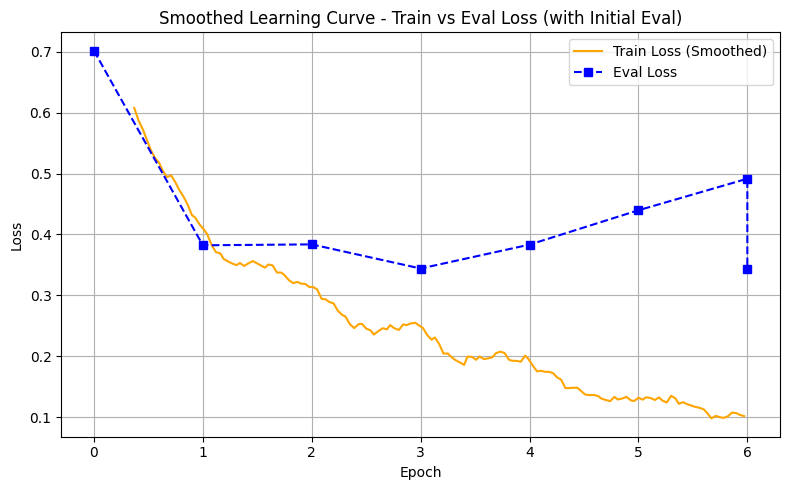

In [15]:
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

# Pastikan df_log_eval diambil dari log asli
df_log_eval = df_log[df_log['eval_loss'].notnull()].copy()

# Tambahkan eval_loss awal (epoch 0) sebagai DataFrame
initial_eval_row = pd.DataFrame([{
    "epoch": 0.0,
    "eval_loss": initial_eval["eval_loss"]
}])

# Gabungkan
df_log_eval = pd.concat([initial_eval_row, df_log_eval], ignore_index=True)
df_log_eval = df_log_eval.sort_values("epoch").reset_index(drop=True)

# Train loss dengan smoothing
df_log_train = df_log[df_log['loss'].notnull()].copy()
window_size = 10
df_log_train["smoothed_loss"] = df_log_train["loss"].rolling(window=window_size).mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(df_log_train["epoch"], df_log_train["smoothed_loss"],
         label="Train Loss (Smoothed)", color="orange")

plt.plot(df_log_eval["epoch"], df_log_eval["eval_loss"],
         label="Eval Loss", marker="s", linestyle="--", color="blue")

plt.title("Smoothed Learning Curve - Train vs Eval Loss (with Initial Eval)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_with_eval.png", dpi=300)
plt.show()

In [30]:
best_checkpoint = "./results/checkpoint-1072"
best_model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint)
best_trainer = Trainer(model=best_model,tokenizer=tokenizer)
print(best_checkpoint)

./results/checkpoint-1072


In [20]:
preds=best_trainer.predict(test_dataset)
y_pred=preds.predictions.argmax(axis=1)
print(classification_report(y_test,y_pred,target_names=["Bukan Ucapan Perundung","Ucapan Perundung"]))

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 268/268 [01:37<00:00,  2.75it/s]

                        precision    recall  f1-score   support

Bukan Ucapan Perundung       0.86      0.88      0.87      1070
      Ucapan Perundung       0.88      0.86      0.87      1070

              accuracy                           0.87      2140
             macro avg       0.87      0.87      0.87      2140
          weighted avg       0.87      0.87      0.87      2140



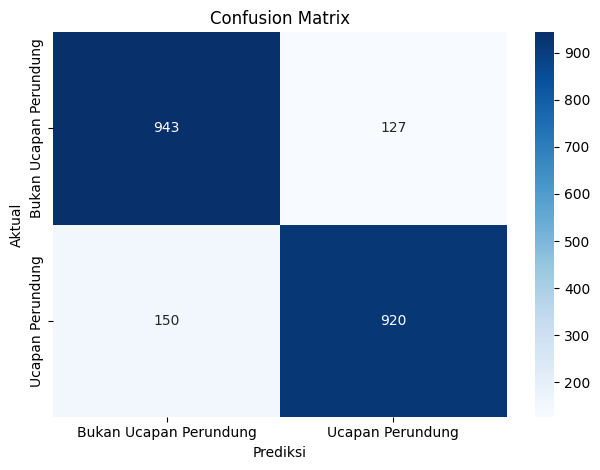

In [21]:
cm=confusion_matrix(y_test,y_pred)

sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=["Bukan Ucapan Perundung","Ucapan Perundung"],
            yticklabels=["Bukan Ucapan Perundung","Ucapan Perundung"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

<h1>Save Model</h1>

In [27]:
best_model.save_pretrained("model_perundung_xlm_roberta")
tokenizer.save_pretrained("model_perundung_xlm_roberta")

('model_perundung_xlm_roberta\\tokenizer_config.json',
 'model_perundung_xlm_roberta\\special_tokens_map.json',
 'model_perundung_xlm_roberta\\sentencepiece.bpe.model',
 'model_perundung_xlm_roberta\\added_tokens.json',
 'model_perundung_xlm_roberta\\tokenizer.json')

<h1>Testing Menggunakan Data Asli</h1>

In [7]:
hasil_model=AutoModelForSequenceClassification.from_pretrained("model_perundung_xlm_roberta")
hasil_tokenizer=AutoTokenizer.from_pretrained("model_perundung_xlm_roberta")
pipe = TextClassificationPipeline(model=hasil_model, tokenizer=hasil_tokenizer)


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [8]:
kalimat_list = [
  
    "Kamu cuma beban buat kelas ini.",
    "Ngaca deh sebelum ikut lomba, nggak malu apa?",
    "Dasar anak cupu, nggak bisa ngapa-ngapain.",
    "Gendut banget sih, jalan aja susah.",
    "Pantes aja nggak punya temen, kelakuanmu nyebelin banget.",
    
   
    "Wah, gayamu keren banget, kayak badut ulang tahun.",
    "Nilaimu tinggi banget ya, sampe nyentuh dasar laut.",
    "Kamu tuh terlalu spesial… sampe semua orang pengen ngejauh.",
    
   
    "Aku tahu kamu lagi capek, tapi aku percaya kamu bisa.",
    "Semangat terus ya, kamu punya potensi besar!"
    
]

for kalimat in kalimat_list:
    hasil = pipe(kalimat)[0]
    print(f"{kalimat} → {hasil['label']} (Score: {hasil['score']:.3f})")


Kamu cuma beban buat kelas ini. → Ucapan Perundung (Score: 0.816)
Ngaca deh sebelum ikut lomba, nggak malu apa? → Bukan Ucapan Perundung (Score: 0.992)
Dasar anak cupu, nggak bisa ngapa-ngapain. → Ucapan Perundung (Score: 0.991)
Gendut banget sih, jalan aja susah. → Ucapan Perundung (Score: 0.978)
Pantes aja nggak punya temen, kelakuanmu nyebelin banget. → Ucapan Perundung (Score: 0.953)
Wah, gayamu keren banget, kayak badut ulang tahun. → Bukan Ucapan Perundung (Score: 0.937)
Nilaimu tinggi banget ya, sampe nyentuh dasar laut. → Bukan Ucapan Perundung (Score: 0.992)
Kamu tuh terlalu spesial… sampe semua orang pengen ngejauh. → Ucapan Perundung (Score: 0.503)
Aku tahu kamu lagi capek, tapi aku percaya kamu bisa. → Bukan Ucapan Perundung (Score: 0.992)
Semangat terus ya, kamu punya potensi besar! → Bukan Ucapan Perundung (Score: 0.987)
